In [4]:
import jax
jax.devices()

[cuda(id=0)]

In [15]:
%pip install bartz

In [16]:
import time

from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt
import bartz

In [37]:
# DGP config
n = 20000 # number of datapoints (train + test)
p = 1 # number of covariates
sigma = 0.1 # noise standard deviation
def f(x): # conditional mean
    R = 2
    r2 = jnp.einsum('ij,ij->j', x, x)
    return jnp.cos(2 * jnp.pi / R * jnp.sqrt(r2))

# generate data
key = random.key(202403142235)
key, key1, key2, key3 = random.split(key, 4)
X = random.normal(key1, (p, n))
y = f(X) + sigma * random.normal(key2, (n,))

# split in train/test
n_train = n // 2
X_train, X_test = X[:, :n_train], X[:, n_train:]
y_train, y_test = y[:n_train], y[n_train:]

class Timer:

    def __init__(self, name):
        self.name = name
        self.start = time.perf_counter()

    def __enter__(self):
        return self

    def __exit__(self, *exc):
        self.end = time.perf_counter()
        print(f'{self.name}: {self.end - self.start:.2f} s')

def task():
    return bartz.BART.gbart(X_train, y_train, x_test=X_test, ntree=10, nskip=500, ndpost=500, seed=key3)
with jax.default_device(jax.devices('cpu')[0]), Timer('bartz on cpu'):
    bart = task()
with jax.default_device(jax.devices('gpu')[0]), Timer('bartz on gpu'):
    bart = task()

Iteration  100/1000 P_grow=0.60 P_prune=0.40 A_grow=0.33 A_prune=0.00 (burnin)
Iteration  200/1000 P_grow=0.80 P_prune=0.20 A_grow=0.00 A_prune=0.00 (burnin)
Iteration  300/1000 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00 (burnin)
Iteration  400/1000 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00 (burnin)
Iteration  500/1000 P_grow=0.70 P_prune=0.30 A_grow=0.00 A_prune=0.00 (burnin)
Iteration  600/1000 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00
Iteration  700/1000 P_grow=0.60 P_prune=0.40 A_grow=0.17 A_prune=0.00
Iteration  800/1000 P_grow=0.10 P_prune=0.90 A_grow=0.00 A_prune=0.11
Iteration  900/1000 P_grow=0.60 P_prune=0.40 A_grow=0.00 A_prune=0.00
Iteration 1000/1000 P_grow=0.70 P_prune=0.30 A_grow=0.00 A_prune=0.00
bartz on cpu: 58.72 s
Iteration  100/1000 P_grow=0.60 P_prune=0.40 A_grow=0.33 A_prune=0.00 (burnin)
Iteration  200/1000 P_grow=0.80 P_prune=0.20 A_grow=0.00 A_prune=0.00 (burnin)
Iteration  300/1000 P_grow=0.50 P_prune=0.50 A_grow=0.00 A_prune=0.00 (burn

In [21]:
# compute RMSE
resid = y_test - bart.yhat_test_mean
rmse = jnp.sqrt(resid @ resid / resid.size)
print(f'data sdev = {y_test.std():#.2g}')
print(f'sigma: {bart.sigma.mean():#.2g} (true: {sigma:#.2g})')
print(f'RMSE: {rmse.item():#.2g}')

data sdev = 0.74
sigma: 0.42 (true: 0.10)
RMSE: 0.79


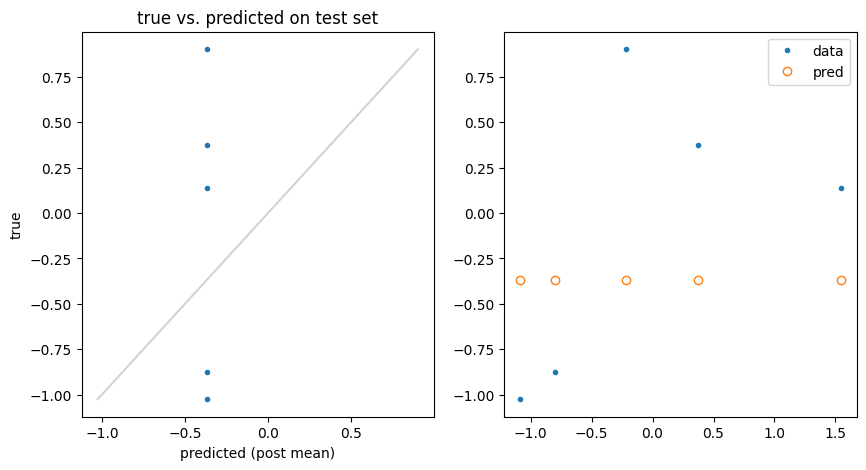

In [22]:
# plot true vs. predicted
fig, axs = plt.subplots(1, 2, num='example1', clear=True, figsize=[10, 5])

ax = axs[0]
l = min(jnp.nanmin(bart.yhat_test_mean), y_test.min())
h = max(jnp.nanmax(bart.yhat_test_mean), y_test.max())
ax.plot([l, h], [l, h], color='lightgray')
ax.plot(bart.yhat_test_mean, y_test, '.')
ax.set(xlabel='predicted (post mean)', ylabel='true', title='true vs. predicted on test set')

ax = axs[1]
ax.plot(X_test[0], y_test, '.', label='data')
ax.plot(X_test[0], bart.yhat_test_mean, 'o', label='pred', markerfacecolor='none')
ax.legend()